# AG NEWS NLP PROJECT

AG News is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Science/Technology”) of AG’s Corpus. This dataset is also commonly used for experimenting with Natural Language Processing and more specifically text classification models in the machine learning community. I will download it from the Hugging Face website.

You can check the papers about the models that achieve the state-of-the-art results on this dataset from this link: https://paperswithcode.com/sota/text-classification-on-ag-news. 

I will go through several modelling experiments to display my knowledge in natural language processing and to see how close I can get to the state of the art results. 

Modelling Experiments Outline:

* `Model_0 (Baseline)`: Multinomial Naive Bayes with TD-IDF
* `Model_1`: 1D Convolutional Neural Network With Custom Token Embeddings
* `Model_2`: Universal Sentence Encoder Feature Extraction
* `Model_3`: 1D Convolutional Neural Network With Custom Token Embeddings Combined With Bi-LSTM With Custom Character Embeddings 
* `Model_4`: LSTM Model With BERT Feature Extraction 
* `Model_5`: 1D Convolutional Neural Network With BERT Tokem Embeddings Combined With Bi-LSTM With Custom Character Embeddings 

## Importing the Dependencies

In [ ]:
!pip install datasets

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install transformers

In [ ]:
!pip install wordcloud

In [ ]:
from datasets import list_datasets, list_metrics, load_dataset
from pprint import pprint

import pandas as pd
import numpy as np
import re
import string
import random
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from tensorflow.keras import mixed_precision

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as stop_words  

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Donwloading the Dataset

In [ ]:
# Accessing various attributes of the ag_news dataset before downloading it
datasets = list_datasets()
metrics = list_metrics()
dataset_info = list_datasets(with_details=True)[datasets.index('ag_news')]
pprint(dataset_info.__dict__['description'])

('AG is a collection of more than 1 million news articles. News articles have '
 'been\n'
 'gathered from more than 2000 news sources by ComeToMyHead in more than 1 '
 'year of\n'
 'activity. ComeToMyHead is an academic news search engine which has been '
 'running\n'
 'since July, 2004. The dataset is provided by the academic comunity for '
 'research\n'
 'purposes in data mining (clustering, classification, etc), information '
 'retrieval\n'
 '(ranking, search, etc), xml, data compression, data streaming, and any '
 'other\n'
 'non-commercial activity. For more information, please refer to the link\n'
 'http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .\n'
 '\n'
 "The AG's news topic classification dataset is constructed by Xiang Zhang\n"
 '(xiang.zhang@nyu.edu) from the dataset above. It is used as a text\n'
 'classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, '
 'Yann\n'
 'LeCun. Character-level Convolutional Networks for Text Classification. '
 

In [ ]:
dataset = load_dataset('ag_news')

## Exploring the Dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
# Looking at a sample from the training dataset
dataset['train'][0]

{'label': 2,
 'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}

In [ ]:
# Visualizing the label counts
pd.Series(dataset['train']['label']).value_counts()

3    30000
2    30000
1    30000
0    30000
dtype: int64

In [ ]:
pd.Series(dataset['test']['label']).value_counts()

3    1900
2    1900
1    1900
0    1900
dtype: int64

Both datasets are prefectly balanced

The labels are encoded accordingly:

* 0: World
* 1: Sports
* 2: Business
* 3: Sci/Tech

For more information you can check the link: https://huggingface.co/datasets/ag_news

In [ ]:
# Creating variables for class names and number of classes
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
num_classes = len(class_names)

In [ ]:
# Creating different variables for train and test sets
train_dataset = pd.DataFrame(dataset['train'])
test_dataset = pd.DataFrame(dataset['test'])
print(len(train_dataset), len(test_dataset))

120000 7600


### Checking the Word Counts

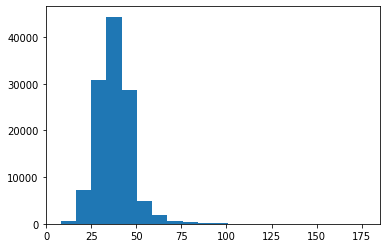

In [ ]:
# Checking the statement length distribution for the training set
train_statement_lengths = [len(statement.split()) for statement in train_dataset['text']]
plt.hist(train_statement_lengths, bins=20);

In [ ]:
# Finding the maximum and minimum statement lengths
max(train_statement_lengths), min(train_statement_lengths)

(177, 8)

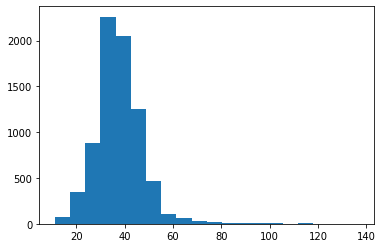

In [ ]:
# Checking the statement length distribution for the test set
test_statement_lengths = [len(statement.split()) for statement in test_dataset['text']]
plt.hist(test_statement_lengths, bins=20);

In [ ]:
# Finding the maximum and minimum statement lengths
max(test_statement_lengths), min(test_statement_lengths)

(137, 11)

### Checking the Character counts

In [ ]:
# creating a function to remove spaces from text and testing on a random sentence
def remove_space(text):
  return ''.join(text.split())

random_text = random.choice(train_dataset['text'])
remove_space(random_text)

"ChinasetforsurgeincarsalesThenumberofcarsonChina'sroadsissettorisesevenfoldto140millionby2020,accordingtogovernmentforecasts."

In [ ]:
# getting number of characters in the random sentence
len(remove_space(random_text))

125

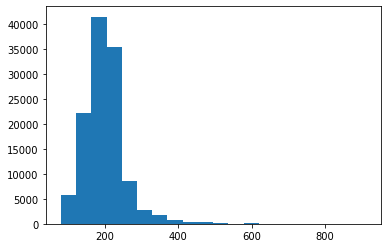

In [ ]:
# Checking the character count distribution for the train set
train_char_count = [len(remove_space(text)) for text in train_dataset['text']]
plt.hist(train_char_count, bins=20);

In [ ]:
# Finding the maximum and minimum character counts
max(train_char_count), min(train_char_count)

(911, 79)

In [ ]:
# Checking the character length that covers 95% of the statements
output_char_len = int(np.percentile(train_char_count, 95))
output_char_len 

290

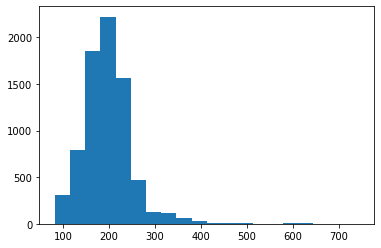

In [ ]:
# Checking the character count distribution for the test set
test_char_count = [len(remove_space(text)) for text in test_dataset['text']]
plt.hist(test_char_count, bins=20);

In [ ]:
# Finding the maximum and minimum character counts
max(test_char_count), min(test_char_count)

(744, 82)

### Checking the Average Word Lenghts

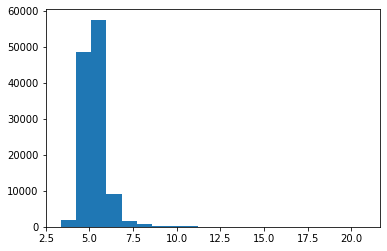

In [ ]:
# Checking the distribution of average word lengths for the training dataset
train_avg_word_len = np.array(train_char_count) / np.array(train_statement_lengths) 
plt.hist(train_avg_word_len, bins=20);

In [ ]:
# Finding the maximum and minimum average word lengths
max(train_avg_word_len), min(train_avg_word_len)

(20.8, 3.357142857142857)

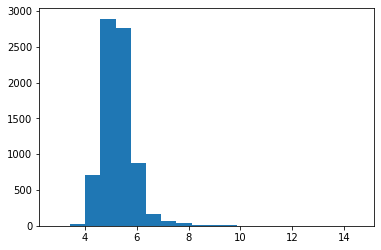

In [ ]:
# Checking the distribution of average word lengths for the training dataset
test_avg_word_len = np.array(test_char_count) / np.array(test_statement_lengths) 
plt.hist(test_avg_word_len, bins=20);

In [ ]:
# Finding the maximum and minimum average word lengths
max(test_avg_word_len), min(test_avg_word_len)

(14.588235294117647, 2.8260869565217392)

## Preprocessing the Data

### Removing the Unwanted Words and Characters

In [ ]:
# creating a function to remove unwanted words
def remove_unwanted(text):
    #remove urls
    text = re.sub(r'http\S+', '', text)
    
    #remove mentions
    text = re.sub(r'@\w+','',text)
    
    #remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    #remove html tags
    text = re.sub('r<.*?>','', text)

    #remove emails
    text = re.sub(r'([a-zA-Z0-9+_-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)','', text)

    #remove special caharacters and punctuations
    text = re.sub(r'[^\w ]+','', text)

    #remove stop words 
    text = text.split()
    text = ' '.join([word for word in text if not word in stop_words])

    #remove multiple spaces
    text = ' '.join(text.split())
    
    return text

In [ ]:
# removing the unwanted words from train and test sets
train_dataset['text'] = train_dataset['text'].apply(lambda x: remove_unwanted(x))
test_dataset['text'] = test_dataset['text'].apply(lambda x: remove_unwanted(x))

I lemmatized the text using the function below, but it ended up yielding less accurate models. Therefore, I decided not to use it.

In [ ]:
# creating a function to lemmatize the sentences using SpaCy
nlp = spacy.load('en_core_web_sm')
def lemmatize(text):
  lem_text = []
  doc = nlp(text)
  for token in doc:
    lemma = token.lemma_
    if lemma == '-PRON-' or lemma == 'be':
      lemma = token.text
    lem_text.append(lemma)
  return ' '.join(lem_text)

# lemmatizing the train and test sets using the function
#train_dataset['text'] = train_dataset['text'].apply(lambda x: lemmatize(x))
#test_dataset['text'] = test_dataset['text'].apply(lambda x: lemmatize(x))

In [ ]:
# Visualizing 10 samples from the training dataset
train_dataset.sample(10)

,text,label
72464,Any Command Line Interface Tricks The day I th...,3
113926,Getting Piece DVD Windfall The unexpected wind...,2
99783,Zimbabwe Ruling Party Elects Woman Mugabe Depu...,0
99528,Oil Dips Watches Heating Stocks Weather Reuter...,2
58925,Pocketing salestax receipts pays A bill expect...,2
108887,Hearing prisoners death halted access DENVER A...,0
79436,Stocks US data send Wall Street mixed message ...,2
90891,End line Waterloo s Eurostars cost 130million ...,2
9595,Israel celebrates joy gold medal Israel celebr...,1
76812,Local teams gear tournaments Some local womens...,1


### Checking the Word and Character Counts After Preprocessing

In [ ]:
# Finding the maximum and minimum statement lengths of the train set
train_statement_lengths = [len(statement.split()) for statement in train_dataset['text']]
max(train_statement_lengths), min(train_statement_lengths)

(98, 5)

In [ ]:
# Finding the maximum and minimum statement lengths of the test set
test_statement_lengths = [len(statement.split()) for statement in test_dataset['text']]
max(test_statement_lengths), min(test_statement_lengths)

(82, 8)

In [ ]:
# Finding the maximum and minimum character counts of the train set
train_char_count = [len(remove_space(text)) for text in train_dataset['text']]
max(train_char_count), min(train_char_count)

(687, 22)

In [ ]:
# Finding the maximum and minimum character counts of the test set
test_char_count = [len(remove_space(text)) for text in test_dataset['text']]
max(test_char_count), min(test_char_count)

(546, 50)

In [ ]:
# Checking the word and character length that covers 95% of the statements
output_seq_len = int(np.percentile(train_statement_lengths, 95))
output_char_len = int(np.percentile(train_char_count, 95))
print(output_seq_len , output_char_len) # I will use these numbers for the embedding layers

35 221


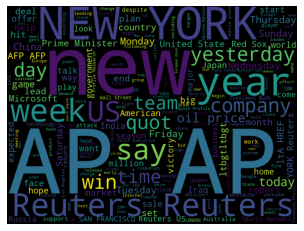

In [ ]:
# Looking at the most common words in the training dataset with wordcloud
wc = WordCloud(width=800, height=600).generate(str(train_dataset['text'].tolist()))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Shuffling the training dataframe
train_dataset = train_dataset.sample(frac=1, random_state=57) # shuffle with random_state=57 for reproducibility
train_dataset.head(10)

,text,label
27510,ABB won t close Guelph transformer plant ABB I...,2
84528,Poison pill News NEWS Corporation yesterday in...,2
96252,Does Your Site Need Custom Search Engine Toolb...,3
92001,Europes Mission Moon Nears Lunar Orbit AP AP A...,3
26401,Neville injury blow United England SvenGoran E...,1
71693,Will Ericssons Future Match Its Past The big S...,2
119751,Langer batting Shoaib bowling AUSTRALIAN opene...,1
44743,Natural gas supply fears raise prices Natural ...,2
105454,Philly Broadband Clash Pits City Against Telco...,3
94525,Court Panel Skeptical About Penalty Sought Aga...,2


In [ ]:
# Creating different variables (lists) for text and labels for each dataset
train_text = train_dataset['text'].tolist()
test_text = test_dataset['text'].tolist()

train_labels = train_dataset['label'].tolist()
test_labels = test_dataset['label'].tolist()

### One Hot Encoding the Labels

In [ ]:
# One hot-encoding the labels for deep models
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_dataset['label'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_dataset['label'].to_numpy().reshape(-1, 1))

# Checking what training labels look like
train_labels_one_hot

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

## Baseline Model: TF-IDF MultinomialNB

In [ ]:
# Creating tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fitting the pipeline to the training data
model_0.fit(train_text, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluating the baseline model on the test set
baseline_score = model_0.score(test_text, test_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 90.34%


## Creating Embedding Layers for the Deep Models


### Custom Token Embedding Layer

In [ ]:
# Creating a text vectorization layer 
text_vectorizer = TextVectorization(output_sequence_length=output_seq_len)

In [ ]:
# Adapting the text vectorizer to training text data
text_vectorizer.adapt(train_text)

In [ ]:
# Testing out the text vectorizer on a random text
print(f"Text:\n{random_text}")
print(f"\nLength of text: {len(random_text.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_text])}")

Text:
China set for surge in car sales The number of cars on China's roads is set to rise sevenfold to 140 million by 2020, according to government forecasts.

Length of text: 28

Vectorized text:
[[   54    84   234  1439    70   250    51     3   306  1194  1562   386
   1834  5085   436    84   327   216 12680   327  6074    25   232 13324
    115   327    38  1628     0     0     0     0     0     0     0]]


In [ ]:
# Checking the length of the vocab size and top 5 most and least common words
ag_news_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(ag_news_text_vocab)}"), 
print(f"Most common words in the vocabulary: {ag_news_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {ag_news_text_vocab[-5:]}")

Number of words in vocabulary: 99442
Most common words in the vocabulary: ['', '[UNK]', 's', 'the', 'new']
Least common words in the vocabulary: ['0029', '0013', '000th', '000strong', '000660se']


In [ ]:
# Creating the embedding layer
token_embed = layers.Embedding(input_dim=len(ag_news_text_vocab),
                               output_dim=128, # I chose 128, but it is a hyperparameter and we can experiment with different numbers
                               mask_zero=True, 
                               name='token_embedding')

In [ ]:
# Testing the embedding layer on a random sample
print(f"Sentence before vectorization:\n{random_text}\n")
vectorized_sentence = text_vectorizer([random_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
China set for surge in car sales The number of cars on China's roads is set to rise sevenfold to 140 million by 2020, according to government forecasts.

Sentence after vectorization (before embedding):
[[   54    84   234  1439    70   250    51     3   306  1194  1562   386
   1834  5085   436    84   327   216 12680   327  6074    25   232 13324
    115   327    38  1628     0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.0370551   0.0468812   0.03741826 ...  0.00056567 -0.03041171
    0.01040962]
  [ 0.04747046  0.02994457  0.03140098 ... -0.00418973  0.04414089
    0.01426586]
  [ 0.03581959  0.03309718 -0.00379197 ... -0.02889127  0.02904263
   -0.02822962]
  ...
  [-0.03970214 -0.04948744 -0.04524931 ...  0.00584563  0.02893848
    0.00139649]
  [-0.03970214 -0.04948744 -0.04524931 ...  0.00584563  0.02893848
    0.00139649]
  [-0.03970214 -0.04948744 -0.04524931 ...  0.00584563  0.02893848
    0.00139649]]]

Embedded sente

### Custom Character Embedding Layer

In [ ]:
# Getting all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Making a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Testing the function on the random sample
split_chars(random_text)

"C h i n a   s e t   f o r   s u r g e   i n   c a r   s a l e s   T h e   n u m b e r   o f   c a r s   o n   C h i n a ' s   r o a d s   i s   s e t   t o   r i s e   s e v e n f o l d   t o   1 4 0   m i l l i o n   b y   2 0 2 0 ,   a c c o r d i n g   t o   g o v e r n m e n t   f o r e c a s t s ."

In [ ]:
# Turning sequence-level data splits into character-level data splits
train_chars = [split_chars(text) for text in train_text]
test_chars = [split_chars(text) for text in test_text]
train_chars[0]

'A B B   w o n   t   c l o s e   G u e l p h   t r a n s f o r m e r   p l a n t   A B B   I n c   r e v e r s e d   d e c i s i o n   c l o s e   t r a n s f o r m e r   p l a n t   G u e l p h   O n t   s a v i n g   3 0 0   j o b s   u n i o n   r e p r e s e n t i n g   w o r k e r s   s a i d   t o d a y'

In [ ]:
# Creating char-level token vectorizer instance
num_char_tokens = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,  
                                    output_sequence_length= output_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapting character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Checking character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 38
5 most common characters: ['', '[UNK]', 'e', 'a', 's']
5 least common characters: ['3', '6', '7', '9', '8']


In [ ]:
# Creating the character level embedding layer
char_embed = layers.Embedding(input_dim=num_char_tokens,
                              output_dim=128, 
                              mask_zero=True,
                              name="char_embed")

### Universal Sentence Encoder Embedding Layer

In [ ]:
# Downloading pretrained TensorFlow Hub USE
use_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name='universal_sentence_encoder')

### BERT Embedding Layer

In [ ]:
# Downloading the Bert Transformer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", 
    trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]
bert_embedding_model = tf.keras.Model(text_input, sequence_output)

In [ ]:
print(f"Sentence before vectorization:\n{random_text}\n")
embedded_sentence = bert_embedding_model(tf.constant([random_text]))
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
China set for surge in car sales The number of cars on China's roads is set to rise sevenfold to 140 million by 2020, according to government forecasts.

Sentence after embedding:
[[[-0.33936295  0.22299519  0.44540325 ... -0.8828875   0.11533178
   -0.4628067 ]
  [-0.08179057  0.24933182  0.03145268 ... -0.40474126  0.21335815
    0.03783422]
  [ 0.03266663 -0.6893445   0.03407557 ... -0.40354085 -0.28535998
   -0.8547112 ]
  ...
  [-0.33698827 -0.26451302  0.4510485  ...  0.17903574  0.41359633
   -0.39136598]
  [-0.04254387  0.0712024   0.6734934  ... -0.0028372   0.08432634
   -0.0979014 ]
  [-0.04282092 -0.10402124  0.58558345 ...  0.1128632   0.15181841
   -0.0729937 ]]]

Embedded sentence shape: (1, 128, 768)


## Creating Datasets for the Deep Models


I am going to set up our data to run as fast as possible with TensorFlow tf.data.API, many of the steps here are discussed at length in these two resources:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.float64)>

In [ ]:
# Batching the TensorSlicedDatasets and prefetching them
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None,), (None, 4)), types: (tf.string, tf.float64)>
<PrefetchDataset shapes: ((None,), (None, 4)), types: (tf.string, tf.float64)>


In [ ]:
# Creating datasets with combined character level and token level data
char_token_train =  tf.data.Dataset.from_tensor_slices((train_text, train_chars)) 
char_token_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((char_token_train, char_token_train_labels))

# Prefetching and batching the train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeating the same process for the test dataset
char_token_test = tf.data.Dataset.from_tensor_slices((test_text, test_chars)) 
char_token_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_char_token_dataset = tf.data.Dataset.zip((char_token_test, char_token_test_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Deep Modelling Experiments

In [ ]:
# Turning on mixed precision training
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
# Creating a function to evaluate the models in terms of accuracy, precision, recall, f1 and save the results
results = {}
def evaluate_model(model, test_data):
  model_accuracy = model.evaluate(test_data)[1]
  y_pred_probs = model.predict(test_data) # getting the prediction probabilities
  y_pred = tf.argmax(y_pred_probs, axis=1) # turning the prediction probabilities into prediction classes
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  results[f'{model.name}'] =  model_results

### Model 1: Conv1D with Custom Token Embeddings

In [ ]:
# Creating the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_1_conv1d_token_embedding')

# compiling the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_conv1d_token_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 35)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 35, 128)           12728576  
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 12,769,860
Trainable params: 12,769,860
Non-trainable params: 0
________________________

In [ ]:
# fitting the model
model_1_hist = model_1.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=10,
                           validation_data=test_dataset,
                           validation_steps = int(0.1*len(test_dataset)))

Epoch 1/10
375/375 [==============================] - 9s 20ms/step - loss: 0.5750 - accuracy: 0.8114 - val_loss: 0.4101 - val_accuracy: 0.8696
Epoch 2/10
375/375 [==============================] - 7s 19ms/step - loss: 0.3085 - accuracy: 0.9007 - val_loss: 0.3745 - val_accuracy: 0.8777
Epoch 3/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2823 - accuracy: 0.9108 - val_loss: 0.3494 - val_accuracy: 0.8967
Epoch 4/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2841 - accuracy: 0.9085 - val_loss: 0.3405 - val_accuracy: 0.8764
Epoch 5/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2534 - accuracy: 0.9193 - val_loss: 0.3153 - val_accuracy: 0.8927
Epoch 6/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2652 - accuracy: 0.9087 - val_loss: 0.2934 - val_accuracy: 0.8995
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2424 - accuracy: 0.9204 - val_loss: 0.2877 - val_accuracy: 0.8995

In [ ]:
evaluate_model(model_1, test_dataset)

238/238 [==============================] - 1s 4ms/step - loss: 0.2481 - accuracy: 0.9171


### Model 2: Universal Sentence Encoder Feature Extraction Model

In [ ]:
# Creating the model
inputs = layers.Input(shape=(), dtype=tf.string)
embeddings = use_embedding(inputs)
x = layers.Dense(128, activation='relu')(embeddings)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_2_USE_token_embedding')

# compiling the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_token_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 256,880,516
Trainable params: 82,692
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# fitting the model
model_2_hist = model_2.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=10,
                           validation_data=test_dataset,
                           validation_steps = int(0.1*len(test_dataset)))

Epoch 1/10
375/375 [==============================] - 11s 21ms/step - loss: 0.4331 - accuracy: 0.8570 - val_loss: 0.4019 - val_accuracy: 0.8668
Epoch 2/10
375/375 [==============================] - 7s 19ms/step - loss: 0.3222 - accuracy: 0.8863 - val_loss: 0.3478 - val_accuracy: 0.8845
Epoch 3/10
375/375 [==============================] - 7s 19ms/step - loss: 0.3047 - accuracy: 0.8925 - val_loss: 0.3512 - val_accuracy: 0.8832
Epoch 4/10
375/375 [==============================] - 7s 20ms/step - loss: 0.3032 - accuracy: 0.8924 - val_loss: 0.3395 - val_accuracy: 0.8872
Epoch 5/10
375/375 [==============================] - 7s 20ms/step - loss: 0.2830 - accuracy: 0.9006 - val_loss: 0.3384 - val_accuracy: 0.8832
Epoch 6/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2949 - accuracy: 0.8946 - val_loss: 0.3359 - val_accuracy: 0.8764
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2808 - accuracy: 0.9022 - val_loss: 0.3345 - val_accuracy: 0.887

In [ ]:
evaluate_model(model_2, test_dataset)

238/238 [==============================] - 4s 17ms/step - loss: 0.2932 - accuracy: 0.8987


### Model 3: Conv1D with Custom Token Embeddings Combined with Caracter Level Embeddings with Bi-LSTM Layers

In [ ]:
# resetting the learned patterns from the previous experiments
text_vectorizer.adapt(train_text)
token_embed = layers.Embedding(input_dim=len(ag_news_text_vocab),
                               output_dim=128,
                               mask_zero=True, 
                               name='token_embedding')

In [ ]:
# Setting up token inputs/model
token_inputs = token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
token_output = layers.Dense(64, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setting up character inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(char_embeddings)
char_bi_lstm2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(char_bi_lstm)
char_output = layers.LSTM(64)(char_bi_lstm2)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_output)

# 3. Concatenating token and char inputs 
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Creating output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constructing the multimodal model with character and token inputs
model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_3_bilstm_char_conv1d_token_embedding")

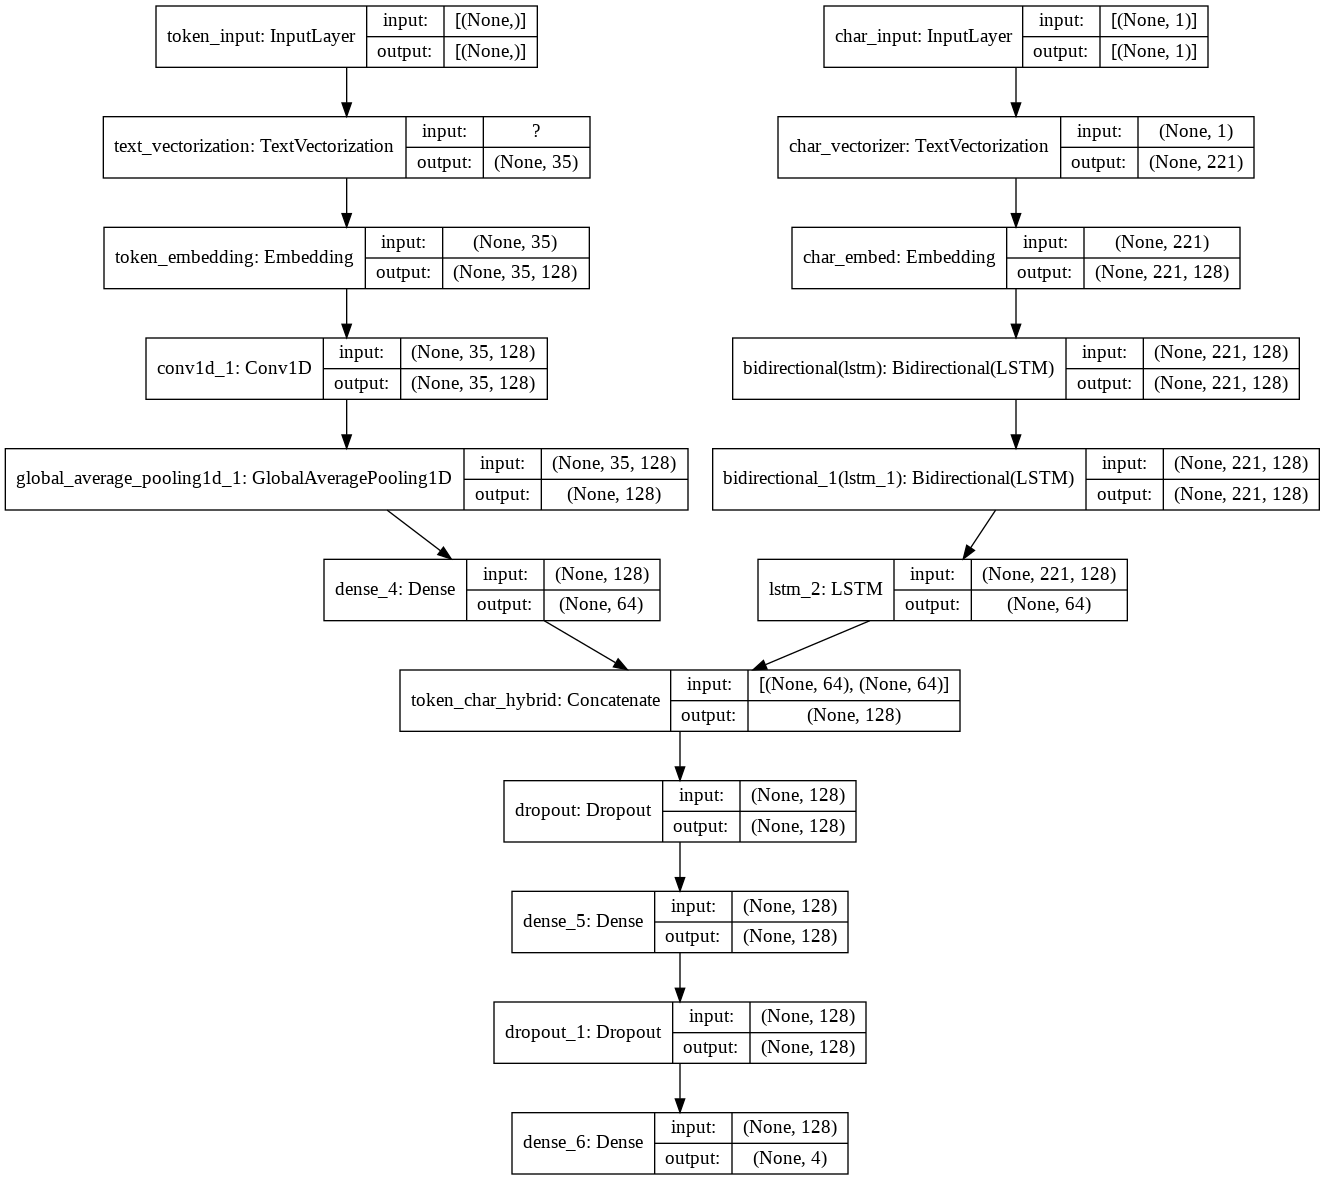

In [ ]:
# Plotting the hybrid token and character model
plot_model(model_3, show_shapes=True)

In [ ]:
# compiling the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
# fitting the model
model_3_hist = model_3.fit(train_char_token_dataset, 
                            steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            epochs=10,
                            validation_data=test_char_token_dataset,
                            validation_steps=int(0.1 * len(test_char_token_dataset)))

Epoch 1/10
375/375 [==============================] - 127s 281ms/step - loss: 0.7259 - accuracy: 0.7044 - val_loss: 0.4303 - val_accuracy: 0.8601
Epoch 2/10
375/375 [==============================] - 98s 262ms/step - loss: 0.3749 - accuracy: 0.8907 - val_loss: 0.3924 - val_accuracy: 0.8682
Epoch 3/10
375/375 [==============================] - 98s 261ms/step - loss: 0.3320 - accuracy: 0.9007 - val_loss: 0.3735 - val_accuracy: 0.8845
Epoch 4/10
375/375 [==============================] - 98s 261ms/step - loss: 0.3317 - accuracy: 0.9013 - val_loss: 0.3510 - val_accuracy: 0.8764
Epoch 5/10
375/375 [==============================] - 98s 261ms/step - loss: 0.2931 - accuracy: 0.9126 - val_loss: 0.3290 - val_accuracy: 0.9022
Epoch 6/10
375/375 [==============================] - 98s 261ms/step - loss: 0.3049 - accuracy: 0.9039 - val_loss: 0.3030 - val_accuracy: 0.9062
Epoch 7/10
375/375 [==============================] - 98s 261ms/step - loss: 0.2811 - accuracy: 0.9154 - val_loss: 0.3062 - val_a

In [ ]:
evaluate_model(model_3, test_char_token_dataset)

238/238 [==============================] - 22s 91ms/step - loss: 0.2512 - accuracy: 0.9197


### Model 4: BERT Feature Extraction Model With LSTM Layers

In [ ]:
# Creating the model
inputs = layers.Input(shape=(), dtype=tf.string)
token_embeddings = bert_embedding_model(inputs)
x = layers.LSTM(128, return_sequences=True)(token_embeddings)
x = layers.LSTM(64)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_4 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_4_bert_token_embedding_lstm')

# compiling the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
model_4.summary()

Model: "model_4_bert_token_embedding_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
model (Functional)           (None, 128, 768)          109482241 
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 128)          459264    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 109,991,173
Trainable params: 508,932
Non-trainable params: 109,482,241
_________________________________________________________________


In [ ]:
# fitting the model
model_4_hist = model_4.fit(train_dataset, 
                            steps_per_epoch=int(0.1 * len(train_dataset)),
                            epochs=10,
                            validation_data=test_dataset,
                            validation_steps=int(0.1 * len(test_dataset)))

Epoch 1/10
375/375 [==============================] - 280s 713ms/step - loss: 0.4202 - accuracy: 0.8513 - val_loss: 0.4756 - val_accuracy: 0.8274
Epoch 2/10
375/375 [==============================] - 266s 708ms/step - loss: 0.3585 - accuracy: 0.8767 - val_loss: 0.3796 - val_accuracy: 0.8832
Epoch 3/10
375/375 [==============================] - 266s 709ms/step - loss: 0.3386 - accuracy: 0.8877 - val_loss: 0.3867 - val_accuracy: 0.8777
Epoch 4/10
375/375 [==============================] - 266s 709ms/step - loss: 0.3253 - accuracy: 0.8880 - val_loss: 0.3534 - val_accuracy: 0.8872
Epoch 5/10
375/375 [==============================] - 265s 708ms/step - loss: 0.2953 - accuracy: 0.9004 - val_loss: 0.3639 - val_accuracy: 0.8913
Epoch 6/10
375/375 [==============================] - 265s 707ms/step - loss: 0.2987 - accuracy: 0.8973 - val_loss: 0.3376 - val_accuracy: 0.8886
Epoch 7/10
375/375 [==============================] - 266s 709ms/step - loss: 0.2745 - accuracy: 0.9062 - val_loss: 0.3236 -

In [ ]:
evaluate_model(model_4, test_dataset)

238/238 [==============================] - 149s 624ms/step - loss: 0.2656 - accuracy: 0.9088


### Model 5: Conv1D with BERT Token Embeddings Combined With Character Level Embeddings with a Bi-LSTM Layer

In [ ]:
# resetting character vectorizer and the embedding layer
char_vectorizer.adapt(train_chars)
char_embed = layers.Embedding(input_dim=num_char_tokens,
                              output_dim=256, 
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Setting up token inputs/model
token_inputs = token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = bert_embedding_model(token_inputs)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
token_output = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setting up character inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenating token and char inputs 
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Creating output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constructing the multimodal model with character and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_5_conv1d_bert_token_and_bilstm_char_embeddings")

# compiling the model
model_5.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

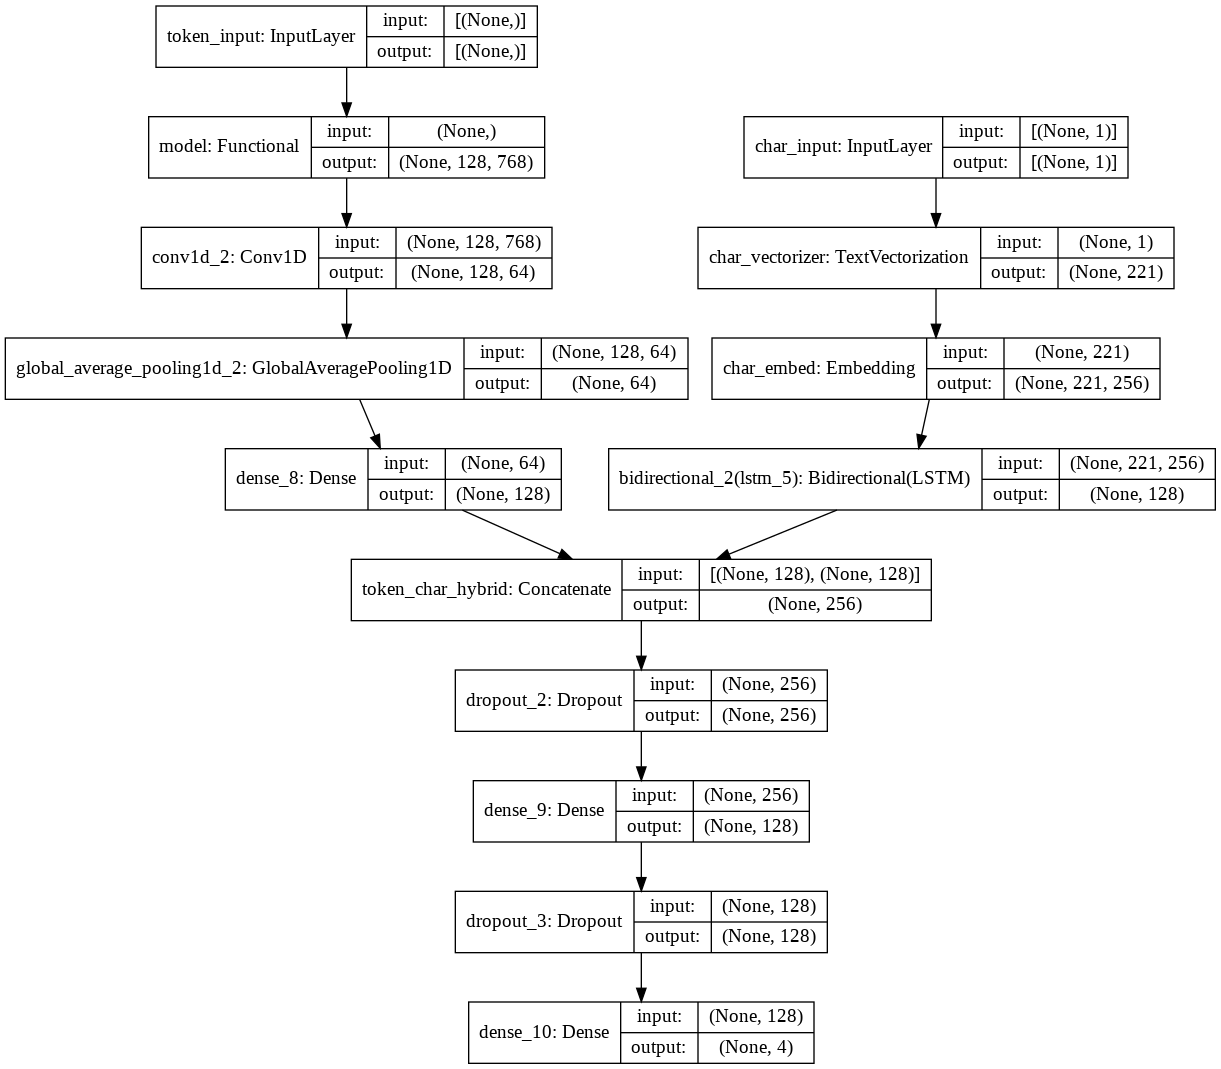

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
# fitting the model
model_5_hist = model_5.fit(train_char_token_dataset, 
                            steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            epochs=10,
                            validation_data=test_char_token_dataset,
                            validation_steps=int(0.1 * len(test_char_token_dataset)))

Epoch 1/10
375/375 [==============================] - 294s 755ms/step - loss: 0.4726 - accuracy: 0.8403 - val_loss: 0.4290 - val_accuracy: 0.8696
Epoch 2/10
375/375 [==============================] - 280s 746ms/step - loss: 0.3703 - accuracy: 0.8809 - val_loss: 0.3557 - val_accuracy: 0.8886
Epoch 3/10
375/375 [==============================] - 280s 746ms/step - loss: 0.3469 - accuracy: 0.8899 - val_loss: 0.3652 - val_accuracy: 0.8804
Epoch 4/10
375/375 [==============================] - 279s 745ms/step - loss: 0.3412 - accuracy: 0.8888 - val_loss: 0.3797 - val_accuracy: 0.8750
Epoch 5/10
375/375 [==============================] - 279s 744ms/step - loss: 0.3196 - accuracy: 0.8986 - val_loss: 0.3597 - val_accuracy: 0.8845
Epoch 6/10
375/375 [==============================] - 279s 745ms/step - loss: 0.3223 - accuracy: 0.8941 - val_loss: 0.3431 - val_accuracy: 0.8886
Epoch 7/10
375/375 [==============================] - 279s 744ms/step - loss: 0.3023 - accuracy: 0.9020 - val_loss: 0.3252 -

In [ ]:
evaluate_model(model_5, test_char_token_dataset)

238/238 [==============================] - 149s 626ms/step - loss: 0.2914 - accuracy: 0.9029


## Comparing The Model Results

In [ ]:
# Getting the precision, recall and f1 scores for the baseline model
y_preds = model_0.predict(test_text)
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels, y_preds, average="weighted")
baseline_results = {"accuracy": baseline_score,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

In [ ]:
# Adding the baseline results to the results dictionary 
results['baseline_multinomialNB'] = baseline_results

In [ ]:
# Converting the results dictionary into a pandas dataframe
results_df = pd.DataFrame.from_dict(results).transpose()
results_df.sort_values('accuracy', ascending=False)

,accuracy,precision,recall,f1
model_3_bilstm_char_conv1d_token_embedding,0.919737,0.919744,0.919737,0.919636
model_1_conv1d_token_embedding,0.917105,0.917020,0.917105,0.916928
model_4_bert_token_embedding_lstm,0.908816,0.909080,0.908816,0.908676
baseline_multinomialNB,0.903421,0.903014,0.903421,0.903150
model_5_conv1d_bert_token_and_bilstm_char_embeddings,0.902895,0.903337,0.902895,0.902609
model_2_USE_token_embedding,0.898684,0.899170,0.898684,0.898695


## Saving The Best Model

In [ ]:
model_3.save('drive/MyDrive/agnews_bestmodel')

INFO:tensorflow:Assets written to: drive/MyDrive/agnews_bestmodel/assets


INFO:tensorflow:Assets written to: drive/MyDrive/agnews_bestmodel/assets


## Most Wrong Predictions Of The Best Model

In [ ]:
# getting the test data's prediction probabilities and getting the classes with the highest probability for each sample
test_pred_probs = model_3.predict(test_char_token_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10].numpy()

238/238 [==============================] - 21s 88ms/step


array([2, 3, 3, 3, 3, 3, 3, 3, 3, 2])

In [ ]:
# revisiting the class names
class_names

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
# Getting a list of class names of the test predictions
test_pred_classes = [class_names[pred] for pred in test_preds]
test_pred_classes[:10]

['Business',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Business']

In [ ]:
# Creating prediction-enriched test dataframe
test_df = pd.DataFrame(dataset['test'])
test_df['class_name'] = [class_names[label] for label in test_df['label'].tolist()]
test_df["prediction"] = test_pred_classes # creating column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # getting the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["class_name"] # creating a binary column for whether the prediction is right or not
test_df.head(20)

,text,label,class_name,prediction,pred_prob,correct
0,Fears for T N pension after talks Unions repre...,2,Business,Business,0.947754,True
1,The Race is On: Second Private Team Sets Launc...,3,Sci/Tech,Sci/Tech,0.998047,True
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Sci/Tech,Sci/Tech,0.934082,True
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Sci/Tech,Sci/Tech,0.766113,True
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Sci/Tech,Sci/Tech,0.868164,True
5,Open Letter Against British Copyright Indoctri...,3,Sci/Tech,Sci/Tech,0.868164,True
6,"Loosing the War on Terrorism \\""Sven Jaschan, ...",3,Sci/Tech,Sci/Tech,0.996094,True
7,"FOAFKey: FOAF, PGP, Key Distribution, and Bloo...",3,Sci/Tech,Sci/Tech,0.791016,True
8,E-mail scam targets police chief Wiltshire Pol...,3,Sci/Tech,Sci/Tech,0.844238,True
9,"Card fraud unit nets 36,000 cards In its first...",3,Sci/Tech,Business,0.656738,False


In [ ]:
# Creating a dataframe with the most wrong predictions
top_wrong_preds_df = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)

In [ ]:
# Investigating the most wrong predictions
for num, row in enumerate(top_wrong_preds_df[:10].itertuples()):
  _, text, label, target, prediction, pred_prob, _ = row
  print(f"{num+1}. Target: {target}, Pred: {prediction}, Prob: {pred_prob}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

1. Target: Sci/Tech, Pred: World, Prob: 0.99853515625

Text:
Man arrested for fatally stabbing elderly parents SAITAMA -- A middle-aged man who fatally stabbed his parents has been arrested, police said. Hideo Nakajima, an unemployed man from Soka, Saitama Prefecture, apparently called police shortly before 8 pm, Wednesday.

-----

2. Target: Sci/Tech, Pred: Business, Prob: 0.99853515625

Text:
DreamWorks Animation IPO Set at 29M Shares Underwriters for DreamWorks Animation SKG Inc., producer of the blockbuster "Shrek" movies, Tuesday set the terms of the company's pending initial public offering at 29 million common shares, with an estimated price range of \$23 to \$25 a share.

-----

3. Target: Business, Pred: World, Prob: 0.99853515625

Text:
Nepal blockade 'blow to tourism' Nepal tour operators say tourists cancelled millions of  dollars of bookings due to the rebel blockade of Kathmandu.

-----

4. Target: Business, Pred: World, Prob: 0.998046875

Text:
Megawati kicks off 36th AS

**Analysis:**

Based on the results, I would argue that most of these samples are mislabeled.

First sample is about a man stabbing his parents, which is not science or sechnology news. The second sample is about the initial public offerings of DreamWorks, which I would consider business news rather than science/tech. The 3rd example is about how the rebel blockade of Kathmandu negatively impacted Nepal's tourism. The target is business, however I think world news would be a more adequate class since the news is about a foreign country's internal issues. Similarly, the 5th example is about killings of Russian troops in a school siege which also would be interpreted as world news rather than science or tech news.

On the other hand, there are some samples where the model gets confused and mispredicts the class. The last sample is about the death of a NASA astronaut. I would interpret it as world news, which is also the target. However, the model predicts science/tech which is understandable since there are many science terms included in text like NASA, astronaut and moon landing. 

## Making Example Predictions

In [ ]:
# Setting up the sample news dataset
news1 = {}
news1['text'] = 'United Airlines will require its US staff to be vaccinated against COVID-19. The rule will kick in this fall, CEO Scott Kirby and president Brett Hart said in a memo to staff.'
news1['source'] = 'https://www.cnet.com/health/united-airlines-will-require-staff-to-be-vaccinated/'
news2 = {}
news2['text'] = 'Brazil beat Spain in extra time to retain Olympic football gold'
news2['source'] = 'https://www.aljazeera.com/news/2021/8/7/brazil-beat-spain-in-extra-time-to-retain-olympic-football-gold'
news3 = {}
news3['text'] = "Biden addresses the crisis in Afghanistan after Taliban take Kabul"
news3['source'] = 'https://www.cnbc.com/2021/08/16/watch-biden-afghanistan-speech-live.html'
news4 = {}
news4['text'] = 'Probiotics help lab corals survive deadly heat stress'
news4['source'] = 'https://www.sciencenews.org/article/probiotics-lab-coral-heat-stress-death-reef-survival-ocean-warming'

sample_news = []
sample_news.append(news1)
sample_news.append(news2)
sample_news.append(news3)
sample_news.append(news4)

sample_news_df = pd.DataFrame(sample_news)
sample_news_df['labels'] = [3, 2, 1, 4]
sample_news_df['classes'] = [class_names[label-1] for label in sample_news_df['labels']]
sample_news_df

,text,source,labels,classes
0,United Airlines will require its US staff to b...,https://www.cnet.com/health/united-airlines-wi...,3,Business
1,Brazil beat Spain in extra time to retain Olym...,https://www.aljazeera.com/news/2021/8/7/brazil...,2,Sports
2,Biden addresses the crisis in Afghanistan afte...,https://www.cnbc.com/2021/08/16/watch-biden-af...,1,World
3,Probiotics help lab corals survive deadly heat...,https://www.sciencenews.org/article/probiotics...,4,Sci/Tech


In [ ]:
# Preparing the sample news for predictions
sample_news_df['text'] = sample_news_df['text'].apply(lambda x: remove_unwanted(x))
sample_token_data = sample_news_df['text'].tolist()
sample_char_data = sample_news_df['text'].apply(lambda x: split_chars(x)).tolist()
sample_data = tf.data.Dataset.from_tensor_slices((sample_token_data, sample_char_data))
sample_labels = tf.data.Dataset.from_tensor_slices(sample_news_df['labels'].tolist())
test_sample = tf.data.Dataset.zip((sample_data, sample_labels))

In [ ]:
sample_pred_probs = model_3.predict(test_sample.batch(1))
sample_preds = tf.argmax(sample_pred_probs, axis=1)
pred_classes = [class_names[pred] for pred in sample_preds]
pred_classes

['Business', 'Sports', 'World', 'Sci/Tech']

In [ ]:
sample_news_df['pred'] = pred_classes
sample_news_df['pred_probs'] = tf.reduce_max(sample_pred_probs, axis=1).numpy()
for row in sample_news_df.itertuples():
  _, text, _, label, classes, prediction, pred_prob = row
  print(f"Target: {classes}, Pred: {prediction}, Prob: {pred_prob}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: Business, Pred: Business, Prob: 0.759765625

Text:
United Airlines require US staff vaccinated COVID19 The rule kick fall CEO Scott Kirby president Brett Hart said memo staff

-----

Target: Sports, Pred: Sports, Prob: 0.859375

Text:
Brazil beat Spain extra time retain Olympic football gold

-----

Target: World, Pred: World, Prob: 0.97216796875

Text:
Biden addresses crisis Afghanistan Taliban Kabul

-----

Target: Sci/Tech, Pred: Sci/Tech, Prob: 0.85107421875

Text:
Probiotics help lab corals survive deadly heat stress

-----

